In [47]:
## Import Some Libraries
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [48]:
class LoadModel:
    def __init__(self, file_path):
        with open(file_path, 'r') as f:
            model_data = json.load(f)
        
        self.input_size = model_data['case']['model']['input_size']
        self.model_info = model_data['case']['model']['layers']
        
        self.input = model_data['case']['input']
        self.target = model_data['case']['target']
        
        self.learning_rate = model_data['case']['learning_parameters']['learning_rate']
        self.batch_size = model_data['case']['learning_parameters']['batch_size']
        self.max_iteration = model_data['case']['learning_parameters']['max_iteration']
        self.error_threshold = model_data['case']['learning_parameters']['error_threshold']
        
        self.number_of_layers = len(self.model_info) # excluding input layer
        self.weights = model_data['case']['initial_weights']
        
        self.x = []
        self.nets = []
        self.y = []
        self.errors = []
        self.dE_dO = []
        self.dO_dnet = []
        self.gradients = []
        
        self.reset_dE_dO()
        self.reset_dO_dnet()
        self.reset_gradients()
        
        self.activations = []
        for i in range(self.number_of_layers):
            self.activations.append(self.model_info[i]['activation_function'])
                
    def get_weights(self):
        return self.weights
    
    def get_activations(self):
        return self.activations
    
    def get_model(self):
        return self.weights, self.activations
    
    def get_activation_gradient(self, activation):
        if activation == 'relu':
            return lambda x: 1. * (x > 0)
        elif activation == 'sigmoid':
            return lambda x: x * (1. - x)
        elif activation == 'linear':
            return lambda x: np.ones_like(x)
        elif activation == 'softmax':
            return lambda x: x * (1. - x)
        elif activation == 'sse':
            return lambda x: np.ones_like(x)
    
    def reset_xynets(self):
        self.x = []
        self.nets = []
        self.y = []        
    
    def reset_dE_dO(self):
        self.dE_dO = [[0 for j in range(len(self.weights[0][0]))] for i in range(len(self.weights))]
    
    def reset_dO_dnet(self):
        self.dO_dnet = [[0 for j in range(len(self.weights[0][0]))] for i in range(len(self.weights))]
    
    def reset_gradients(self):
        self.gradients = [[[0 for k in range(len(self.weights[0][0]))] for j in range(len(self.weights[0]))] for i in range(len(self.weights))]
        
    # print model per layer
    def print_model(self):
        print('Input Layer', self.input)
        print('')
        
        for i in range(self.number_of_layers): # layer dengan neuron
            print('Layer', i+1)
            print('Weights:', self.weights[i])
            print('Activations:', self.activations[i])
            print('')

Input Layer [[-1.0]]

Layer 1
Weights: [[0.4, 0.7], [0.2, -0.9]]
Activations: softmax



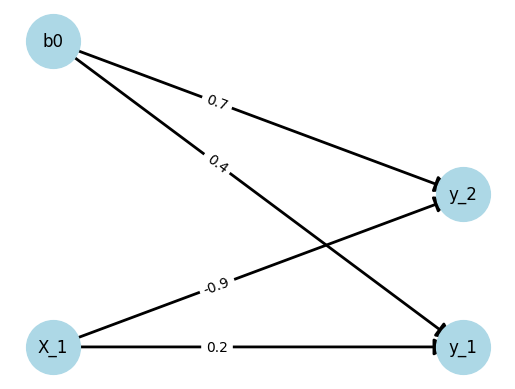

In [49]:
class FFNN:
    def __init__(self, model_path):
        self.model = LoadModel(model_path)
        self.weights = self.model.get_weights()
        self.activations = self.model.get_activations()
    
    def forward_propagation_train(self, X):
        input_layer = X.copy()
                
        for i in range(self.model.number_of_layers): # iterate over layers
            input_layer.insert(0,1) # masukkin bias
            self.model.x.append(input_layer)

            net_layer = []
            for k in range(len(self.weights[0][0])): # iterate over neurons
                neuron_value = 0
                for j in range(len(self.weights[0])): # iterate over input
                    neuron_value += input_layer[j] * self.weights[i][j][k]
                net_layer.append(neuron_value)
            
            self.model.nets.append(net_layer)
               
            output_layer = []
            for net in net_layer :
                result = 0
                if self.activations[i] == 'relu' :
                    result = max(0, net)
                elif self.activations[i] == 'linear' :
                    result = net
                elif self.activations[i] == 'sigmoid' :
                    result = 1 / (1 + math.exp(-net))
                elif self.activations[i] == 'sse':
                    alpha = 1.67326
                    scale = 1.0507
                    result = scale * np.where(net >= 0, net, alpha * (np.exp(net) - 1))
                elif self.activations[i] == 'softmax' :
                    result = math.exp(net) / sum([math.exp(n) for n in net_layer])
                output_layer.append(result)
            
            self.model.y.append(output_layer)
            
            input_layer = output_layer.copy()
            

    def backward_propagation_train(self, X, y_true):
        for i in range(self.model.number_of_layers - 1, -1, -1): # iterate over layers
            gradients = [[0 for col in range(len(self.weights[i][0]))] for row in range(len(self.weights[i]))]
            dE_dO_list = []
            dO_dnet_list = []
            if i == self.model.number_of_layers - 1 : # output layer
                for k in range(len(self.weights[0][0])): # iterate over neurons
                    dE_dO = -(y_true[k] - self.model.y[i][k])
                    
                    if self.activations[i] == 'relu' :
                        dO_dnet = 1 * (self.model.nets[i][k] >= 0)
                    elif self.activations[i] == 'linear' :
                        dO_dnet = 1
                    elif self.activations[i] == 'sigmoid' :
                        dO_dnet = self.model.y[i][k] * (1 - self.model.y[i][k])
                    elif self.activations[i] == 'sse':
                        alpha = 1.67326
                        scale = 1.0507
                        dO_dnet = scale * np.where(self.model.nets[i][k] >= 0, 1, alpha * np.exp(self.model.nets[i][k]))
                    elif self.activations[i] == 'softmax' :
                        dO_dnet = self.model.y[i][k] * (1 - self.model.y[i][k])
                    
                    for j in range(len(self.weights[0])): # iterate over input
                        dnet_dW = self.model.x[i][j]
                        gradient = dE_dO * dO_dnet * dnet_dW
                        gradients[j][k] = gradient
                    
                    dE_dO_list.append(dE_dO)
                    dO_dnet_list.append(dO_dnet)
                    
            else: # hidden layers
                for k in range(len(self.weights[0][0])): # iterate over neurons
                    dE_dO = 0
                    for errors in range(2) :
                        dEi_dOprev = self.model.dE_dO[i+1][errors]
                        dOprev_dnetprev = self.model.dO_dnet[i+1][errors]
                        dEi_dnetprev = dEi_dOprev * dOprev_dnetprev
                        dnetprev_dO = self.model.weights[i+1][k+1][errors]
                        dEi_dO = dEi_dnetprev * dnetprev_dO
                        dE_dO += dEi_dO
                    
                    if self.activations[i] == 'relu' :
                        dO_dnet = 1 * (self.model.nets[i][k] >= 0)
                    elif self.activations[i] == 'linear' :
                        dO_dnet = 1
                    elif self.activations[i] == 'sigmoid' :
                        dO_dnet = self.model.y[i][k] * (1 - self.model.y[i][k])
                    elif self.activations[i] == 'sse':
                        alpha = 1.67326
                        scale = 1.0507
                        dO_dnet = scale * np.where(self.model.nets[i][k] >= 0, 1, alpha * np.exp(self.model.nets[i][k]))   
                    elif self.activations[i] == 'softmax' :
                        dO_dnet = self.model.y[i][k] * (1 - self.model.y[i][k])
                        
                    for j in range(len(self.weights[0])): # iterate over input
                        dnet_dW = self.model.x[i][j]
                        gradient = dE_dO * dO_dnet * dnet_dW
                        gradients[j][k] = gradient
                        
                    dE_dO_list.append(dE_dO)
                    dO_dnet_list.append(dO_dnet)
            
            self.model.gradients[i] = np.add(self.model.gradients[i],gradients)
            self.model.dE_dO[i] = dE_dO_list.copy()
            self.model.dO_dnet[i] = dO_dnet_list.copy()
            
                        
    def train(self):
        for epoch in range(self.model.max_iteration):
            
            batch_counter = 0 # untuk ngingetin update weight
            
            for i in range(len(self.model.input)):
                batch_counter += 1
                self.model.reset_xynets()
                
                self.forward_propagation_train(self.model.input[i])
                self.backward_propagation_train(self.model.input[i], self.model.target[i])
                
                if (batch_counter % self.model.batch_size == 0) :
                    self.update_weights()
                    self.reset_gradients()

            # cek error threshold

    def update_weights(self):
        delta = np.multiply(self.model.gradients, self.model.learning_rate)
        self.model.weights = np.subtract(self.model.weights, delta)
        
    def reset_gradients(self):
        self.model.reset_gradients()

    def print_model(self):
        self.model.print_model()

    def draw_network(self):
        G = nx.DiGraph()

        pos = {}

        # add nodes
        input_nodes = [f'X_{i + 1}' for i in range(len(self.model.weights[0]) - 1)]
        G.add_nodes_from(input_nodes, layer='Input')
        G.add_nodes_from(['b0'], layer='Bias')
        for i in range(len(input_nodes)):   
            pos[f'X_{i + 1}'] = [0, i + 1]
        pos['b0'] = [0, len(self.model.weights[0]) + 1]

        hidden_nodes = []

        for i in range(len(self.model.weights) - 1):
            hidden_nodes.append([f'h{i + 1}_{j + 1}' for j in range(len(self.model.weights[i][0]))])
            G.add_nodes_from(hidden_nodes[i], layer='Hidden')
            G.add_nodes_from([f'b{i + 1}'], layer='Bias')
            for j in range(len(hidden_nodes[i])):
                pos[f'h{i + 1}_{j + 1}'] = [i + 1, j + 1]
            pos[f'b{i + 1}'] = [i + 1, len(self.model.weights[i][0]) + 1]

        output_nodes = [f'y_{i + 1}' for i in range(len(self.model.weights[-1][0]))]
        G.add_nodes_from(output_nodes, layer='Output')
        for i in range(len(output_nodes)):
            pos[f'y_{i + 1}'] = [len(self.model.weights), i + 1]

        # add edges
        for i in range(len(self.model.weights)):
            for j in range(len(self.model.weights[i]) - 1):
                for k in range(len(self.model.weights[i][j])):
                    if len(hidden_nodes) != 0:
                        if i == 0:
                            G.add_edge(f'X_{j + 1}', f'h{i + 1}_{k + 1}', weight=self.model.weights[i][j + 1][k])
                            G.add_edge(f'b{i}', f'h{i + 1}_{k + 1}', weight=self.model.weights[i][0][k])
                        elif i == len(self.model.weights) - 1:
                            G.add_edge(f'h{i}_{j + 1}', f'y_{k + 1}', weight=self.model.weights[i][j + 1][k])
                            G.add_edge(f'b{i}', f'y_{k + 1}', weight=self.model.weights[i][0][k])
                        else:
                            G.add_edge(f'h{i}_{j + 1}', f'h{i + 1}_{k + 1}', weight=self.model.weights[i][j + 1][k])
                            G.add_edge(f'b{i}', f'h{i + 1}_{k + 1}', weight=self.model.weights[i][0][k])
                    else:
                        G.add_edge(f'X_{j + 1}', f'y_{k + 1}', weight=self.model.weights[i][j + 1][k])
                        G.add_edge(f'b{i}', f'y_{k + 1}', weight=self.model.weights[i][0][k])

        # draw network
        edge_labels = nx.get_edge_attributes(G, 'weight')

        nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
        nx.draw_networkx_edges(G, pos, width=2, edge_color='black', arrows=True, arrowsize=25)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.60)
        nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
        plt.axis('off')
        plt.show()


# main function
def main():
    # load model
    # filename = input("Enter the filename: ")
    filename = 'softmax_error_only'
    model_path = filename + '.json'
    model = FFNN(model_path)
    model.print_model()
    
    model.train()

    # print model
    # model.print_model()

    # draw network
    model.draw_network()

if __name__ == '__main__':
    main()